In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from gensim.models import Word2Vec
import re
import pandas as pd
from tqdm import tqdm

In [ ]:
trg_mask = torch.tril(torch.ones((10, 10))).expand(10, 7, 10, 10)

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def data_vocab(tokenized_sentences, vector_size=50, window=5, min_count=1, sg=1):
    all_tokens = [token for pair in tokenized_sentences for sentence in pair for token in sentence]
    word2vec = Word2Vec([all_tokens], vector_size=vector_size, window=window, min_count=min_count, sg=sg)

    special_tokens = ['<pad>', '<sos>', '<eos>', '<sis>', '<unk>']

    vocab = word2vec.wv.key_to_index  # 어휘 사전 구축
    for token in special_tokens:
        if token not in vocab:
            vocab[token] = len(vocab)  # 특수 토큰을 어휘 사전에 추가

    word2idx = {word: idx for word, idx in vocab.items()}  # 단어->인덱스 맵핑
    idx2word = {idx: word for word, idx in word2idx.items()}  # 인덱스->단어 맵핑
    return vocab, word2idx, idx2word

def preprocess_tokenize(sentence):
        sentence = re.sub(r"[^가-힣\s]", "", sentence)  # 한글과 공백을 제외한 모든 문자 제거
        syllables = re.findall(r'[가-힣]|[^\s가-힣]+|\s', sentence)  # 음절 단위로 토큰화
        result = []
        for syllable in syllables:
            if syllable.isspace():  # 공백을 <sis>로 변환
                result.append("<sis>")
            else:
                result.append(syllable)
        return result

def tokens_to_indices(tokens, word2idx):
    indices = [word2idx.get(token, word2idx['<unk>']) for token in tokens]
    return indices

def indices_to_tokens(indices, idx2word):
    return [idx2word.get(idx, '<unk>') for idx in indices]

class TextDataset(Dataset):
    def __init__(self, data, word2idx, max_len = 0):
        self.data = data
        self.word2idx = word2idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        typo, target = self.data[idx]
        self.max_len = max(max(len(src) + 1, len(trg) + 2) for src, trg in self.data)
        word2idx = self.word2idx

        typo_indices = tokens_to_indices(typo, word2idx)
        target_indices = tokens_to_indices(target, word2idx)

        enc_src = self.pad_sequence(typo_indices + [word2idx['<eos>']])
        dec_src = self.pad_sequence([word2idx['<sos>']] + target_indices)
        trg = self.pad_sequence([word2idx['<sos>']] + target_indices + [word2idx['<eos>']])

        return torch.tensor(enc_src), torch.tensor(dec_src), torch.tensor(trg)

    def pad_sequence(self, seq):
        return F.pad(torch.LongTensor(seq), (0, self.max_len - len(seq)), mode='constant',
                     value=self.word2idx['<pad>'])

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=3000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.encoding[:, :seq_len, :].to(x.device)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.scale = torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        seq_len = q.size(1)

        q = self.q_linear(q).view(batch_size, self.num_heads,seq_len, self.d_k)
        k = self.k_linear(k).view(batch_size, self.num_heads,seq_len, self.d_k)
        v = self.v_linear(v).view(batch_size, self.num_heads,seq_len, self.d_k)

        scores = torch.matmul(q, k.transpose(2,3)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(mask == 0, -1e20)
        attn = torch.softmax(scores, dim=-1)
        output = torch.matmul(attn, v)
        output = output[0].reshape(batch_size, seq_len, self.num_heads * self.d_k)
        return self.out(output)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
        )

    def forward(self, x):
        return self.feedforward(x)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.attention(x, x, x, mask)
        x = self.dropout(self.norm1(attn_output + x))

        ffn_output = self.ffn(x)
        x = self.norm2(self.dropout(ffn_output + x))
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.attention1 = MultiHeadAttention(d_model, num_heads)
        self.attention2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output1 = self.attention1(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output1))
        attn_output2 = self.attention2(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output2))
        ffn_output = self.ffn(x)
        x = self.norm3(x + self.dropout(ffn_output))
        return x

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, device, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, mask):
        x = self.dropout(self.pos_encoding(self.embedding(src)))
        for layer in self.layers:
            x = layer(x, mask)
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, device, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, enc_output, src_mask, tgt_mask):
        x = self.dropout(self.pos_encoding(self.embedding(tgt)))
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)
        return self.out(x)

class Transformer(nn.Module):
    def __init__(self, device, pad_idx, vocab_size,
                 d_model=512, num_layers=6, num_heads=8, d_ff=2048, dropout=0.1):
        super(Transformer, self).__init__()
        self.pad_idx = pad_idx
        self.device = device

        self.encoder = Encoder(vocab_size, d_model, num_layers, num_heads, d_ff, device, dropout).to(device)
        self.decoder = Decoder(vocab_size, d_model, num_layers, num_heads, d_ff, device, dropout).to(device)


    def make_src_mask(self, src):
        src_mask = (src != self.pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        batch_size, trg_seq_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_seq_len, trg_seq_len))).expand(
            batch_size, 1, trg_seq_len, trg_seq_len)
        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_out = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_out, src_mask, trg_mask)
        return out

In [ ]:
def step(model, enc_src, dec_src, trg, loss_fn, pad_idx, device, i, idx2word):
    enc_src = enc_src.to(device)
    dec_src = dec_src.to(device)
    trg = trg.to(device)

    output = model(enc_src, dec_src)

    output = output[:, :-1, :].contiguous()
    trg = trg[:, 1:].contiguous()

    if i % 50 == 0:
            pass
            #print('Input: ', indices_to_tokens(output.reshape(-1).cpu().detach().numpy(), idx2word))
            #print('Target: ', indices_to_tokens(trg.reshape(-1).cpu().detach().numpy(), idx2word))

    loss = loss_fn(output.view(-1, output.shape[-1]), trg.view(-1))

    non_pad_elements = (trg != pad_idx).nonzero(as_tuple=True)
    correct_predictions = (output.argmax(dim=2) == trg).sum().item()
    accuracy = correct_predictions / len(non_pad_elements[0])

    return loss, accuracy

In [ ]:
def train_step(model, iterator, optimizer, loss_fn, clip, pad_idx, device, idx2word):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for i, datas in enumerate(iterator):

        enc_src, dec_src, trg = datas
        optimizer.zero_grad()

        loss, accuracy = step(model, enc_src, dec_src, trg, loss_fn, pad_idx, device, i, idx2word)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += accuracy

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate_step(model, iterator, loss_fn, pad_idx, device, idx2word):
    model.eval()  # 모델을 평가 모드로 설정합니다.
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():  # 기울기 계산을 비활성화합니다.
        for i, datas in enumerate(iterator):
            enc_src, dec_src, trg = datas

            loss, accuracy = step(model, enc_src, dec_src, trg, loss_fn, pad_idx, device, i, idx2word)

            # 손실과 정확도를 누적합니다.
            epoch_loss += loss.item()
            epoch_acc += accuracy

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def train(model, train_loader, optimizer, loss_fn, clip, epochs, pad_idx, device, idx2word, val_loader=None):
    score = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for _ in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_loader, optimizer, loss_fn, clip, pad_idx, device, idx2word)
        result = f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.3f}%'

        if val_loader:
            eval_loss, eval_acc = evaluate_step(model, val_loader, loss_fn, pad_idx, device, idx2word)
            result += f' || Eval Loss: {eval_loss:.3f} | Eval Acc: {eval_acc * 100:.3f}%'

            score['val_loss'].append(eval_loss)
            score['val_acc'].append(eval_acc)

        score['train_loss'].append(train_loss)
        score['train_acc'].append(train_acc)
        print(result)
        torch.save(model.state_dict(), 'checkpoint.pth')

    return model, score

In [ ]:
data = pd.read_csv('data.csv')
data = list(zip(data['Q_noise'], data['Q']))
print("data size: " + str(len(data)))

tokenized_sentences = [(preprocess_tokenize(src), preprocess_tokenize(trg)) for src, trg in data]
vocab, word2idx, idx2word = data_vocab(tokenized_sentences)
print("vocab size: " + str(len(vocab)))

train_dataset = TextDataset(tokenized_sentences, word2idx)
val_dataset = TextDataset(tokenized_sentences[:1000], word2idx)
print("train_dataset size: " + str(len(train_dataset)))
print("val_dataset size: " + str(len(val_dataset)))

data size: 11823
vocab size: 3549
train_dataset size: 11823
val_dataset size: 1000


In [ ]:
vocab_size = len(word2idx)
d_model = 128
num_layers = 4
num_heads = 2
d_ff = 512
dropout = 0.1
learning_rate = 1e-4
epochs = 50
batch = 64

torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('use :', device)

pad_idx = word2idx['<pad>']

model = Transformer(device, pad_idx,vocab_size, d_model, num_layers, num_heads, d_ff, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

print('parameter: '+ str(count_parameters(model)))

train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=True)

use : cuda
parameter: 3217757


In [ ]:
tokens_to_indices(['<sos>'],word2idx)

[3546]

In [ ]:
model, score = train(model, train_loader, optimizer, criterion, clip=1,
                    epochs=epochs, pad_idx=pad_idx, device=device, val_loader=val_loader, idx2word = idx2word)

  0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-33-7b4f9654ed00>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(enc_src), torch.tensor(dec_src), torch.tensor(trg)
  2%|▏         | 1/50 [01:31<1:14:44, 91.51s/it]

	Train Loss: 5.770 | Train Acc: 20.778% || Eval Loss: 4.502 | Eval Acc: 26.087%


  4%|▍         | 2/50 [03:00<1:11:52, 89.85s/it]

	Train Loss: 4.257 | Train Acc: 28.293% || Eval Loss: 3.917 | Eval Acc: 32.634%


  6%|▌         | 3/50 [04:29<1:10:02, 89.41s/it]

	Train Loss: 3.848 | Train Acc: 32.492% || Eval Loss: 3.634 | Eval Acc: 35.747%


  8%|▊         | 4/50 [05:59<1:08:58, 89.96s/it]

	Train Loss: 3.605 | Train Acc: 35.225% || Eval Loss: 3.397 | Eval Acc: 38.829%


 10%|█         | 5/50 [07:35<1:09:05, 92.13s/it]

	Train Loss: 3.420 | Train Acc: 37.351% || Eval Loss: 3.215 | Eval Acc: 41.021%


 12%|█▏        | 6/50 [09:10<1:08:08, 92.92s/it]

	Train Loss: 3.263 | Train Acc: 39.278% || Eval Loss: 3.027 | Eval Acc: 43.352%


 14%|█▍        | 7/50 [10:48<1:07:51, 94.70s/it]

	Train Loss: 3.127 | Train Acc: 41.182% || Eval Loss: 2.869 | Eval Acc: 45.791%


 16%|█▌        | 8/50 [12:26<1:06:59, 95.69s/it]

	Train Loss: 3.004 | Train Acc: 42.969% || Eval Loss: 2.763 | Eval Acc: 47.238%


 18%|█▊        | 9/50 [14:04<1:05:52, 96.40s/it]

	Train Loss: 2.889 | Train Acc: 44.738% || Eval Loss: 2.598 | Eval Acc: 50.567%


 20%|██        | 10/50 [15:42<1:04:36, 96.91s/it]

	Train Loss: 2.792 | Train Acc: 46.274% || Eval Loss: 2.494 | Eval Acc: 51.830%


 22%|██▏       | 11/50 [17:20<1:03:16, 97.35s/it]

	Train Loss: 2.701 | Train Acc: 47.704% || Eval Loss: 2.401 | Eval Acc: 52.958%


 24%|██▍       | 12/50 [18:58<1:01:38, 97.33s/it]

	Train Loss: 2.613 | Train Acc: 49.071% || Eval Loss: 2.206 | Eval Acc: 56.717%


 26%|██▌       | 13/50 [20:36<1:00:11, 97.61s/it]

	Train Loss: 2.537 | Train Acc: 50.213% || Eval Loss: 2.211 | Eval Acc: 56.227%


 28%|██▊       | 14/50 [22:13<58:26, 97.40s/it]  

	Train Loss: 2.461 | Train Acc: 51.507% || Eval Loss: 2.143 | Eval Acc: 57.669%


 30%|███       | 15/50 [23:50<56:50, 97.44s/it]

	Train Loss: 2.421 | Train Acc: 52.013% || Eval Loss: 2.097 | Eval Acc: 58.127%


 32%|███▏      | 16/50 [25:30<55:31, 97.99s/it]

	Train Loss: 2.341 | Train Acc: 53.425% || Eval Loss: 2.024 | Eval Acc: 59.679%


 34%|███▍      | 17/50 [27:08<53:58, 98.13s/it]

	Train Loss: 2.287 | Train Acc: 54.346% || Eval Loss: 1.901 | Eval Acc: 61.488%


 36%|███▌      | 18/50 [28:48<52:33, 98.56s/it]

	Train Loss: 2.224 | Train Acc: 55.334% || Eval Loss: 1.830 | Eval Acc: 62.652%


 38%|███▊      | 19/50 [30:29<51:21, 99.40s/it]

	Train Loss: 2.214 | Train Acc: 55.270% || Eval Loss: 1.895 | Eval Acc: 61.699%


 40%|████      | 20/50 [32:10<49:54, 99.82s/it]

	Train Loss: 2.153 | Train Acc: 56.458% || Eval Loss: 1.871 | Eval Acc: 61.283%


 42%|████▏     | 21/50 [33:50<48:14, 99.81s/it]

	Train Loss: 2.072 | Train Acc: 58.006% || Eval Loss: 1.718 | Eval Acc: 64.650%


 44%|████▍     | 22/50 [35:32<46:53, 100.47s/it]

	Train Loss: 2.099 | Train Acc: 57.116% || Eval Loss: 1.707 | Eval Acc: 65.020%


 46%|████▌     | 23/50 [37:13<45:20, 100.76s/it]

	Train Loss: 2.019 | Train Acc: 58.655% || Eval Loss: 1.683 | Eval Acc: 65.064%


 48%|████▊     | 24/50 [38:53<43:30, 100.42s/it]

	Train Loss: 2.005 | Train Acc: 58.918% || Eval Loss: 1.509 | Eval Acc: 68.538%


 50%|█████     | 25/50 [40:34<41:59, 100.76s/it]

	Train Loss: 1.956 | Train Acc: 59.607% || Eval Loss: 1.576 | Eval Acc: 67.661%


 52%|█████▏    | 26/50 [42:15<40:20, 100.87s/it]

	Train Loss: 1.951 | Train Acc: 59.663% || Eval Loss: 1.603 | Eval Acc: 66.534%


 54%|█████▍    | 27/50 [43:55<38:33, 100.58s/it]

	Train Loss: 1.894 | Train Acc: 60.762% || Eval Loss: 1.650 | Eval Acc: 65.481%


 56%|█████▌    | 28/50 [45:34<36:42, 100.10s/it]

	Train Loss: 1.864 | Train Acc: 61.265% || Eval Loss: 1.507 | Eval Acc: 68.383%


 58%|█████▊    | 29/50 [47:14<34:59, 99.97s/it] 

	Train Loss: 1.885 | Train Acc: 60.529% || Eval Loss: 1.535 | Eval Acc: 67.443%


 60%|██████    | 30/50 [48:54<33:18, 99.94s/it]

	Train Loss: 1.835 | Train Acc: 61.504% || Eval Loss: 1.532 | Eval Acc: 67.550%


 62%|██████▏   | 31/50 [50:34<31:38, 99.90s/it]

	Train Loss: 1.828 | Train Acc: 61.580% || Eval Loss: 1.456 | Eval Acc: 68.822%


 64%|██████▍   | 32/50 [52:14<29:59, 99.96s/it]

	Train Loss: 1.784 | Train Acc: 62.267% || Eval Loss: 1.425 | Eval Acc: 69.829%


 66%|██████▌   | 33/50 [53:55<28:25, 100.35s/it]

	Train Loss: 1.812 | Train Acc: 61.587% || Eval Loss: 1.491 | Eval Acc: 68.022%


 68%|██████▊   | 34/50 [55:34<26:38, 99.93s/it] 

	Train Loss: 1.725 | Train Acc: 63.464% || Eval Loss: 1.413 | Eval Acc: 69.666%


 70%|███████   | 35/50 [57:14<25:01, 100.10s/it]

	Train Loss: 1.734 | Train Acc: 63.115% || Eval Loss: 1.273 | Eval Acc: 72.511%


 72%|███████▏  | 36/50 [58:56<23:28, 100.64s/it]

	Train Loss: 1.701 | Train Acc: 63.702% || Eval Loss: 1.392 | Eval Acc: 69.594%


 74%|███████▍  | 37/50 [1:00:36<21:44, 100.37s/it]

	Train Loss: 1.724 | Train Acc: 63.066% || Eval Loss: 1.385 | Eval Acc: 69.800%


 76%|███████▌  | 38/50 [1:02:17<20:05, 100.50s/it]

	Train Loss: 1.671 | Train Acc: 63.968% || Eval Loss: 1.260 | Eval Acc: 72.610%


 78%|███████▊  | 39/50 [1:03:55<18:18, 99.85s/it] 

	Train Loss: 1.650 | Train Acc: 64.420% || Eval Loss: 1.273 | Eval Acc: 72.204%


 80%|████████  | 40/50 [1:05:34<16:35, 99.58s/it]

	Train Loss: 1.645 | Train Acc: 64.320% || Eval Loss: 1.271 | Eval Acc: 72.361%


 82%|████████▏ | 41/50 [1:07:15<14:59, 99.95s/it]

	Train Loss: 1.639 | Train Acc: 64.492% || Eval Loss: 1.347 | Eval Acc: 70.022%


 84%|████████▍ | 42/50 [1:08:55<13:19, 99.95s/it]

	Train Loss: 1.622 | Train Acc: 64.742% || Eval Loss: 1.227 | Eval Acc: 73.240%


 86%|████████▌ | 43/50 [1:10:34<11:37, 99.64s/it]

	Train Loss: 1.605 | Train Acc: 65.007% || Eval Loss: 1.173 | Eval Acc: 73.952%


 88%|████████▊ | 44/50 [1:12:13<09:57, 99.58s/it]

	Train Loss: 1.583 | Train Acc: 65.416% || Eval Loss: 1.274 | Eval Acc: 71.653%


 90%|█████████ | 45/50 [1:13:50<08:14, 98.83s/it]

	Train Loss: 1.615 | Train Acc: 64.711% || Eval Loss: 1.331 | Eval Acc: 70.459%


 92%|█████████▏| 46/50 [1:15:27<06:32, 98.21s/it]

	Train Loss: 1.588 | Train Acc: 65.122% || Eval Loss: 1.350 | Eval Acc: 70.073%


 94%|█████████▍| 47/50 [1:17:05<04:54, 98.13s/it]

	Train Loss: 1.559 | Train Acc: 65.701% || Eval Loss: 1.219 | Eval Acc: 72.362%


 96%|█████████▌| 48/50 [1:18:41<03:15, 97.53s/it]

	Train Loss: 1.526 | Train Acc: 66.323% || Eval Loss: 1.175 | Eval Acc: 73.671%


 98%|█████████▊| 49/50 [1:20:19<01:37, 97.56s/it]

	Train Loss: 1.537 | Train Acc: 65.967% || Eval Loss: 1.337 | Eval Acc: 70.150%


100%|██████████| 50/50 [1:21:54<00:00, 98.30s/it]

	Train Loss: 1.506 | Train Acc: 66.626% || Eval Loss: 1.298 | Eval Acc: 70.746%


In [ ]:
import onnx

In [ ]:
!pip install onnx-pytorch

In [ ]:
torch.onnx.export(model, (train_dataset[6][0].to(device), train_dataset[6][1].to(device)) ,'Syllable_Transformer.onnx', input_names=['enc_src', 'dec_src'], output_names=['output'])

<ipython-input-33-7b4f9654ed00>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(enc_src), torch.tensor(dec_src), torch.tensor(trg)


ValueError: not enough values to unpack (expected 2, got 1)

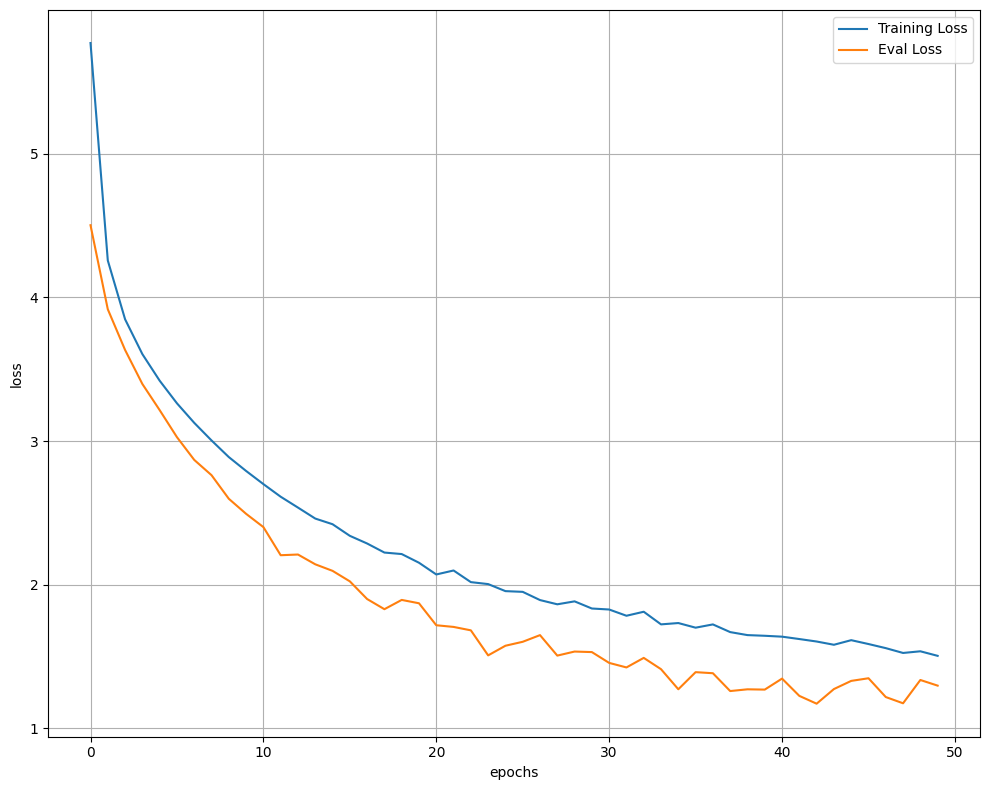

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
plt.plot(list(score['train_loss']), label='Training Loss')
plt.plot(list(score['val_loss']), label='Eval Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss.png', bbox_inches = 'tight')

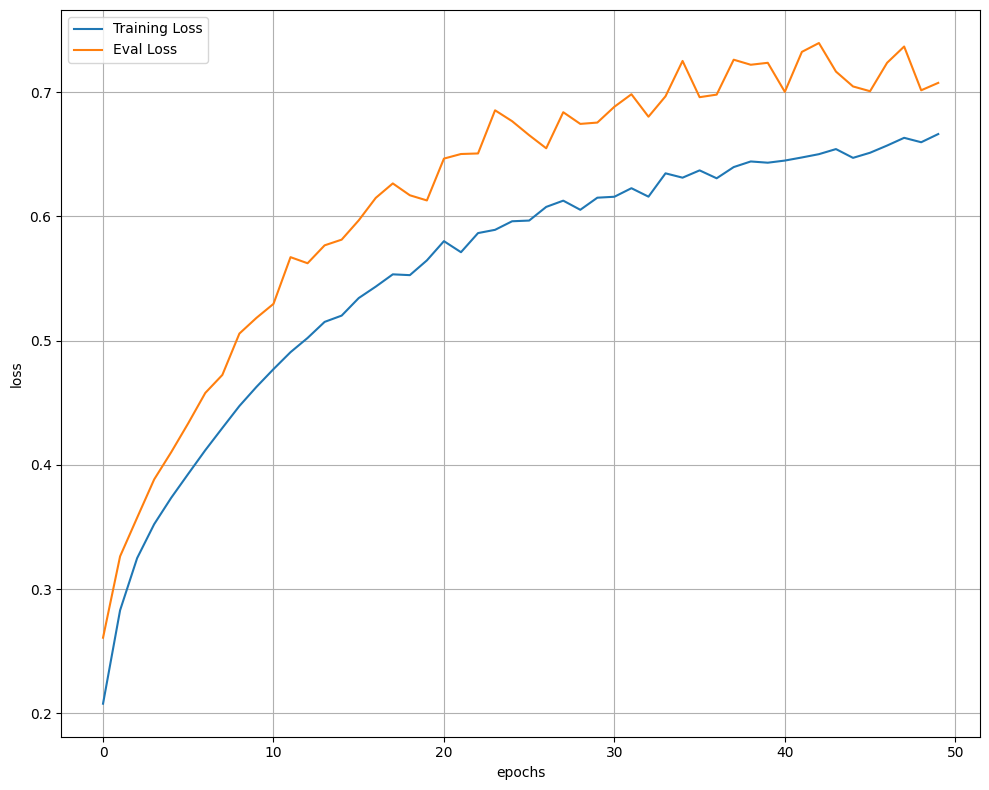

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
plt.plot(list(score['train_acc']), label='Training Loss')
plt.plot(list(score['val_acc']), label='Eval Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('acc.png', bbox_inches = 'tight')